<center><h1><b>Multi Agent Path Finding</b></h1></center> <p>


In [ ]:
import heapq
import matplotlib.pyplot as plt
import itertools

# **Defining the Grid with Obstacles**

In [ ]:
# Creating a n*m grid with obstacles
class Grid:

    def __init__(self, n, m, obstacles):
        self.n = n
        self.m = m
        self.obstacles = obstacles

  # Valid nodes mean the nodes which are not an obstacle and are available for traversal
    def is_valid(self, x, y):
        return 0 <= x < self.n and 0 <= y < self.m and (x, y) not in self.obstacles

Checking if the node is valid for traversal or not. Any node which is a declared obstacle is invalid for traversal.
<p>
Manhattan distance is used as the heuristic for a grid traversal to avoid any diagonal traversal and to ensure smooth travel in a rectangular grid

In [ ]:
class Node:
    # Defining a node based on its coordinates
    def __init__(self, x, y, parent=None):
        self.x = x
        self.y = y
        self.parent = parent
        self.g = 0
        self.h = 0

    """ Comparision of two nodes based on the heuristic value.
    The function returns true iff the heuristic of a node is lesser than
    all other possible nodes """

    def __lt__(self, other):
        # Compare nodes based on their f value (f = g + h)
        return (self.g + self.h) < (other.g + other.h)

def heuristic(node, goal):
    # Manhattan distance heuristic for traversal along a grid
    return (abs(node.x - goal[0]) + abs(node.y - goal[1]))

#**Function for A* search in a grid**

In [ ]:
def astar(grid, start, goal):
    open_set = []
    closed_set = set()

    start_node = Node(start[0], start[1])
    start_node.g = 0
    start_node.h = heuristic(start_node, goal)
    heapq.heappush(open_set, start_node)

    while open_set:
        current_node = heapq.heappop(open_set)

        if (current_node.x, current_node.y) == goal:
            path = []
            while current_node:
                path.append((current_node.x, current_node.y))
                current_node = current_node.parent
            return path[::-1]

        closed_set.add((current_node.x, current_node.y))

        for neighbor in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            x, y = current_node.x + neighbor[0], current_node.y + neighbor[1]

            if not grid.is_valid(x, y) or (x, y) in closed_set:
                continue

            neighbor_node = Node(x, y, current_node)
            neighbor_node.g = current_node.g + 1
            neighbor_node.h = heuristic(neighbor_node, goal)

            if neighbor_node not in open_set:
                heapq.heappush(open_set, neighbor_node)

    return None  # No path found

# **Function for A* search with intermediate goals**
This function takes up the intermediate goal and conducts two seperate A* searches, one from start to intermediate goal and then from intermediate goal to final goal. After finding shortest path for both the routes, the function combines these two.

In [ ]:
def astar_with_intermediate_goals(grid, start, intermediate_goals, goal):
    paths = []
    current_position = start

    for intermediate_goal in intermediate_goals:
        path = astar(grid, current_position, intermediate_goal)
        if path is None:
            return None
        paths.append(path)
        current_position = intermediate_goal

    final_path = astar(grid, current_position, goal)
    if final_path is None:
        return None

    for path in paths:
        final_path.pop(0)  # Remove the duplicate intermediate goal in each path

    return [point for path in paths for point in path] + final_path


# **Functions to Detect and Resolve Conflicts**
Any cell in the grid is termed as a conflict iff two or more agents are **simultaneously** present on it.
For resolving conflicts, we create a new grid with contraints for conflicting agents and resolve their conflicts

In [ ]:
def conflict_detection(paths):
    # Detect conflicts between robot paths
    conflicts = []
    for i in range(len(paths)):
        for j in range(i + 1, len(paths)):
            for t in range(min(len(paths[i]), len(paths[j]))):
                if paths[i][t] == paths[j][t]:
                    conflicts.append((i, j, paths[i][t]))
    return conflicts


def resolve_conflicts(paths, grid):
    while True:
        conflicts = conflict_detection(paths)
        if not conflicts:
            break

        # Choose the first conflict to resolve
        (i, j, t) = conflicts[0]

        # Create a new grid with constraints for the conflicting agents
        new_obstacles = set()
        for k, path in enumerate(paths):
            if k == i or k == j:
                for step in range(t + 1):
                    x, y = path[step]
                    new_obstacles.add((x, y))
        new_grid = Grid(grid.n, grid.m, grid.obstacles | new_obstacles)

        # Re-plan the paths for the conflicting agents
        new_path_i = astar_with_intermediate_goal(new_grid, paths[i][0], paths[i][-1], goal)
        new_path_j = astar_with_intermediate_goal(new_grid, paths[j][0], paths[j][-1], goal)

        if new_path_i is None or new_path_j is None:
            return None  # Conflict resolution failed

        # Update the paths
        paths[i] = new_path_i
        paths[j] = new_path_j

    return paths

# **Plotting and Visualizing the Paths**

In [ ]:
def plot_grid(grid, start, intermediate_goals, goal, path=None, color='blue'):
    plt.xlim(-1, grid.m)
    plt.ylim(-1, grid.n)
    plt.gca().set_aspect('equal', adjustable='box')

    # Plot obstacles
    for obstacle in grid.obstacles:
        plt.scatter(obstacle[1], grid.n - 1 - obstacle[0], color='black', marker='s', s=100)

    # Plot start and goal
    plt.scatter(start[1], grid.n - 1 - start[0],
                color='green', marker='x', s=250, label ='start')
    plt.scatter(goal[1], grid.n - 1 - goal[0],
                color='red', marker='x', s=250, label = 'goal')

    for intermediate in intermediate_goals:
      plt.scatter(intermediate[1], grid.n - 1 - intermediate[0],
                color='orange', marker='x', s=250, label = 'intermediate')


    if path:
        # Plot shortest path
        x, y = zip(*path)
        plt.plot(y, [grid.n - 1 - x for x in x],
                 marker='o', color=color, markersize=5)

    plt.gca()
    plt.grid()
    plt.xticks(list(range(-1, grid.m+1)))
    plt.yticks(list(range(-1, grid.n+1)))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)


# **Testing Conflict-Based Search with pre-defined points**

Initial conflicts: []
Resolved paths:

Agent 1: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 0), (4, 0), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (2, 5), (2, 6), (2, 7), (2, 8), (1, 8), (0, 8), (2, 8), (2, 9), (2, 10), (3, 10), (3, 11), (3, 12)]

Agent 2: [(5, 9), (4, 9), (4, 8), (4, 7), (4, 6), (4, 6), (5, 6), (5, 5), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (2, 9), (1, 9), (1, 10), (0, 10)]

Agent 3: [(1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 12), (2, 12), (2, 13), (2, 14), (3, 14), (3, 15), (3, 13), (3, 12), (3, 11), (3, 10), (3, 9), (2, 9), (1, 9), (0, 9), (0, 8), (0, 7), (0, 6), (0, 5)]

After conflict resolution: []


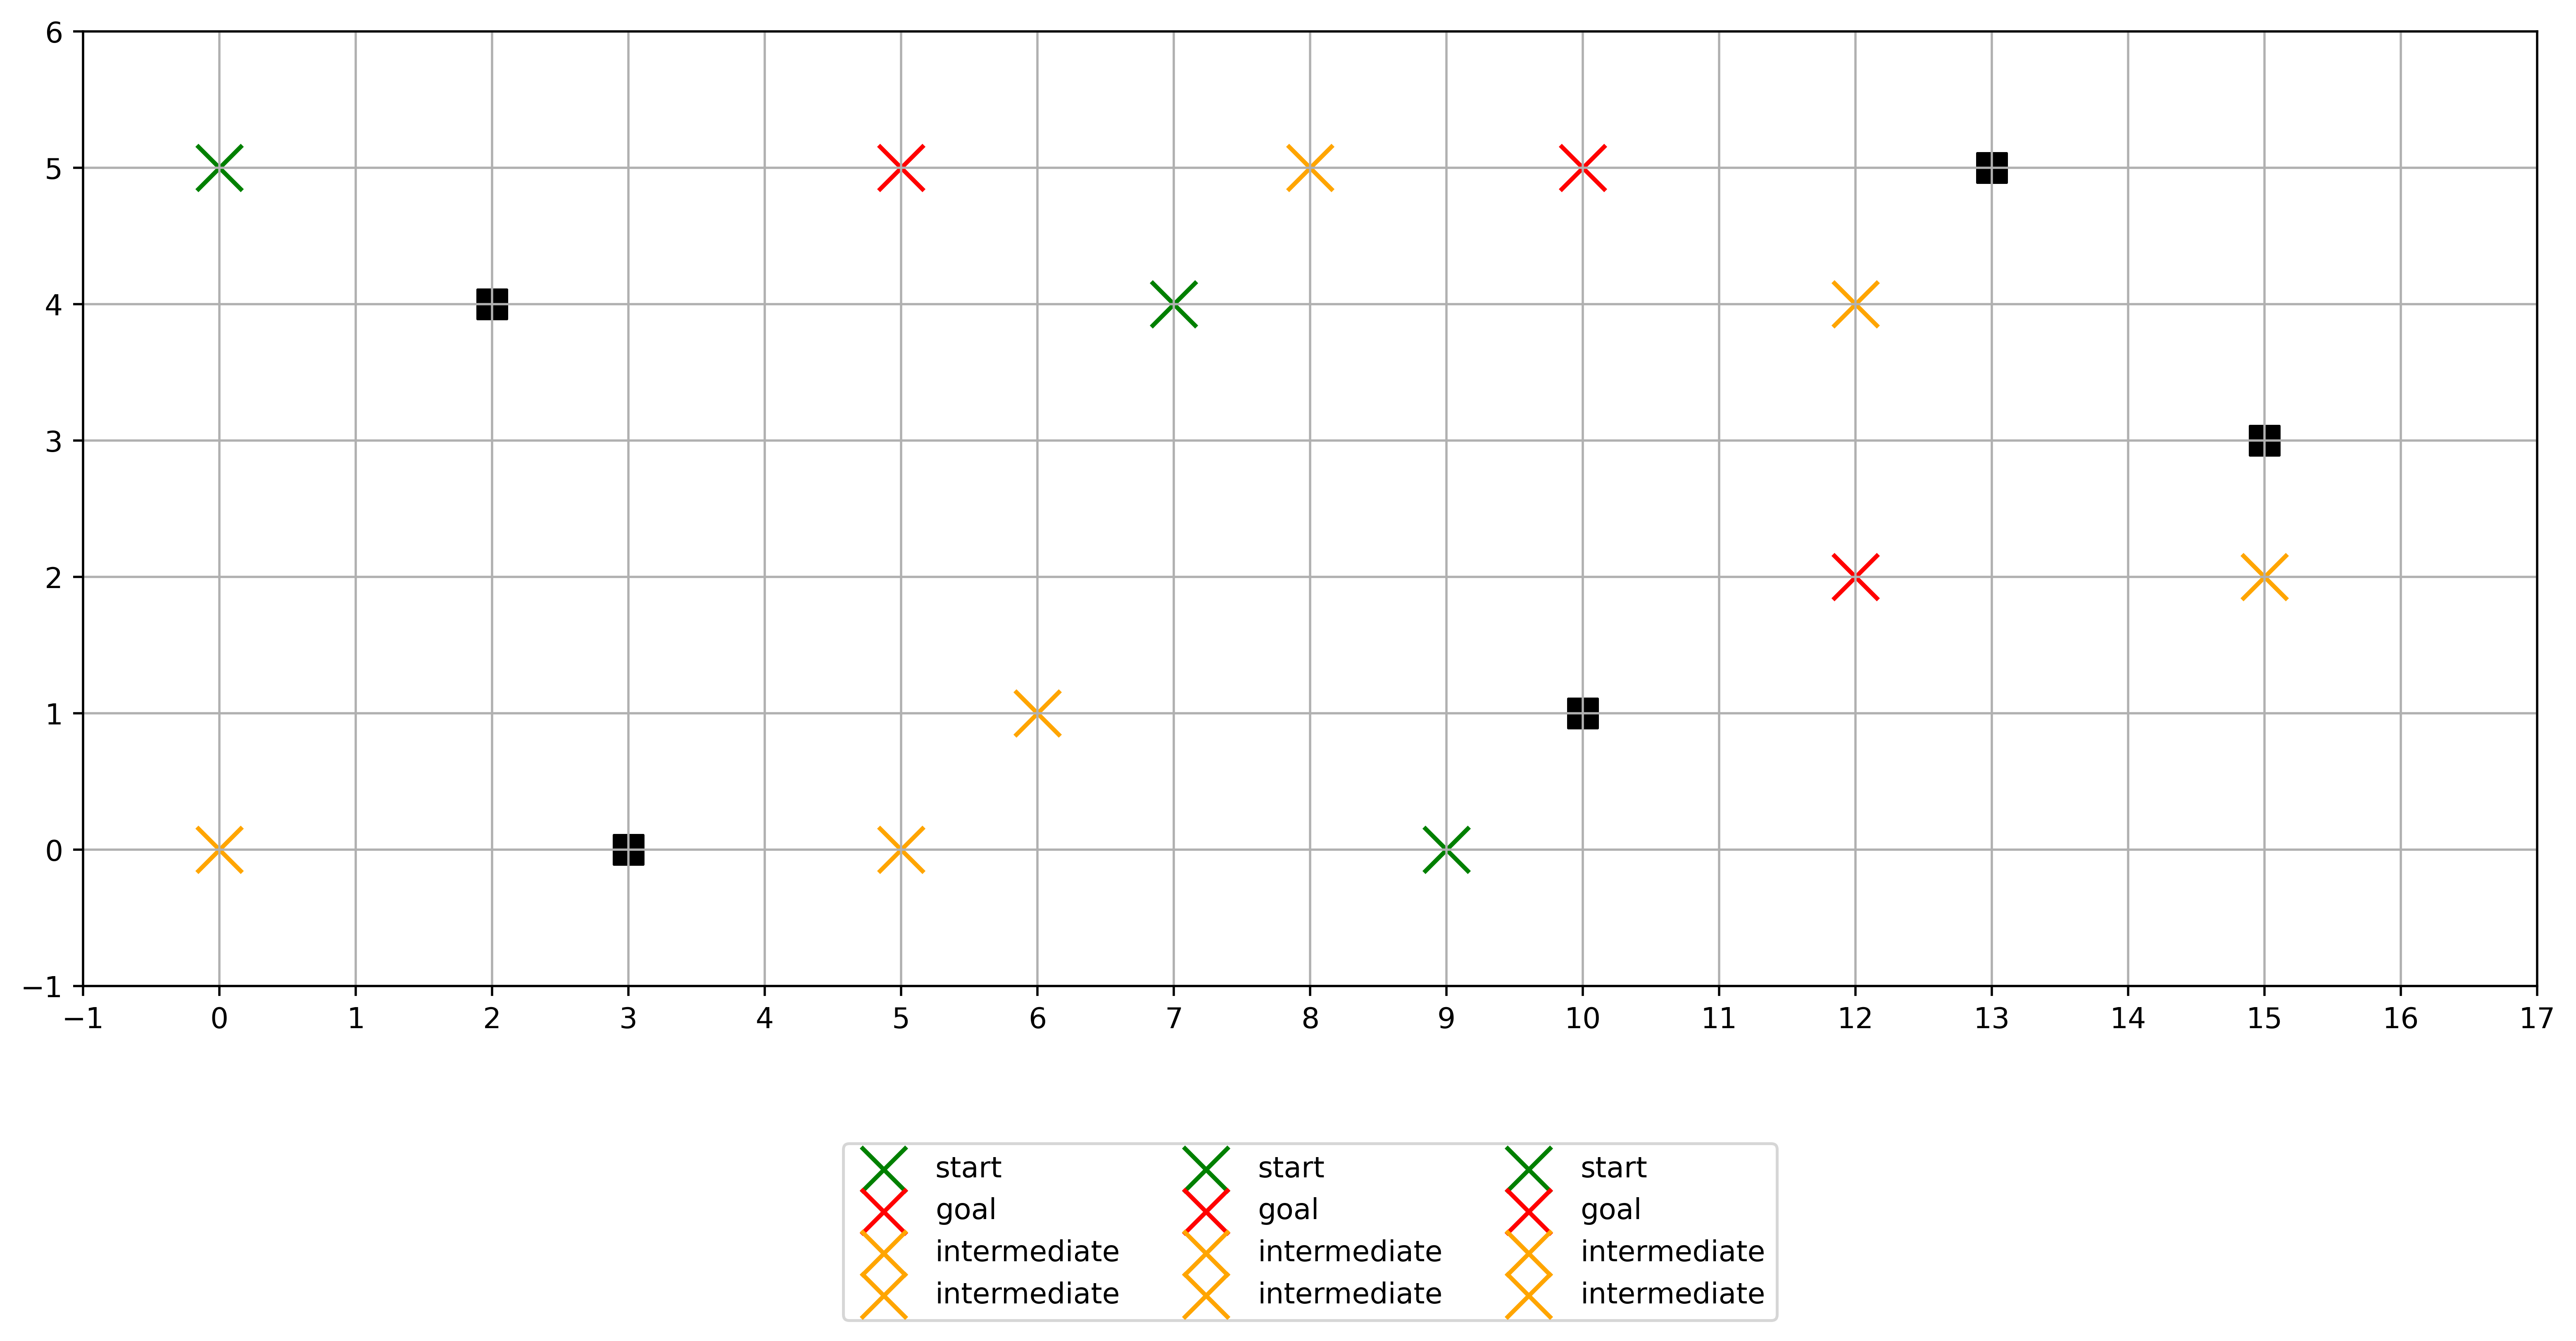

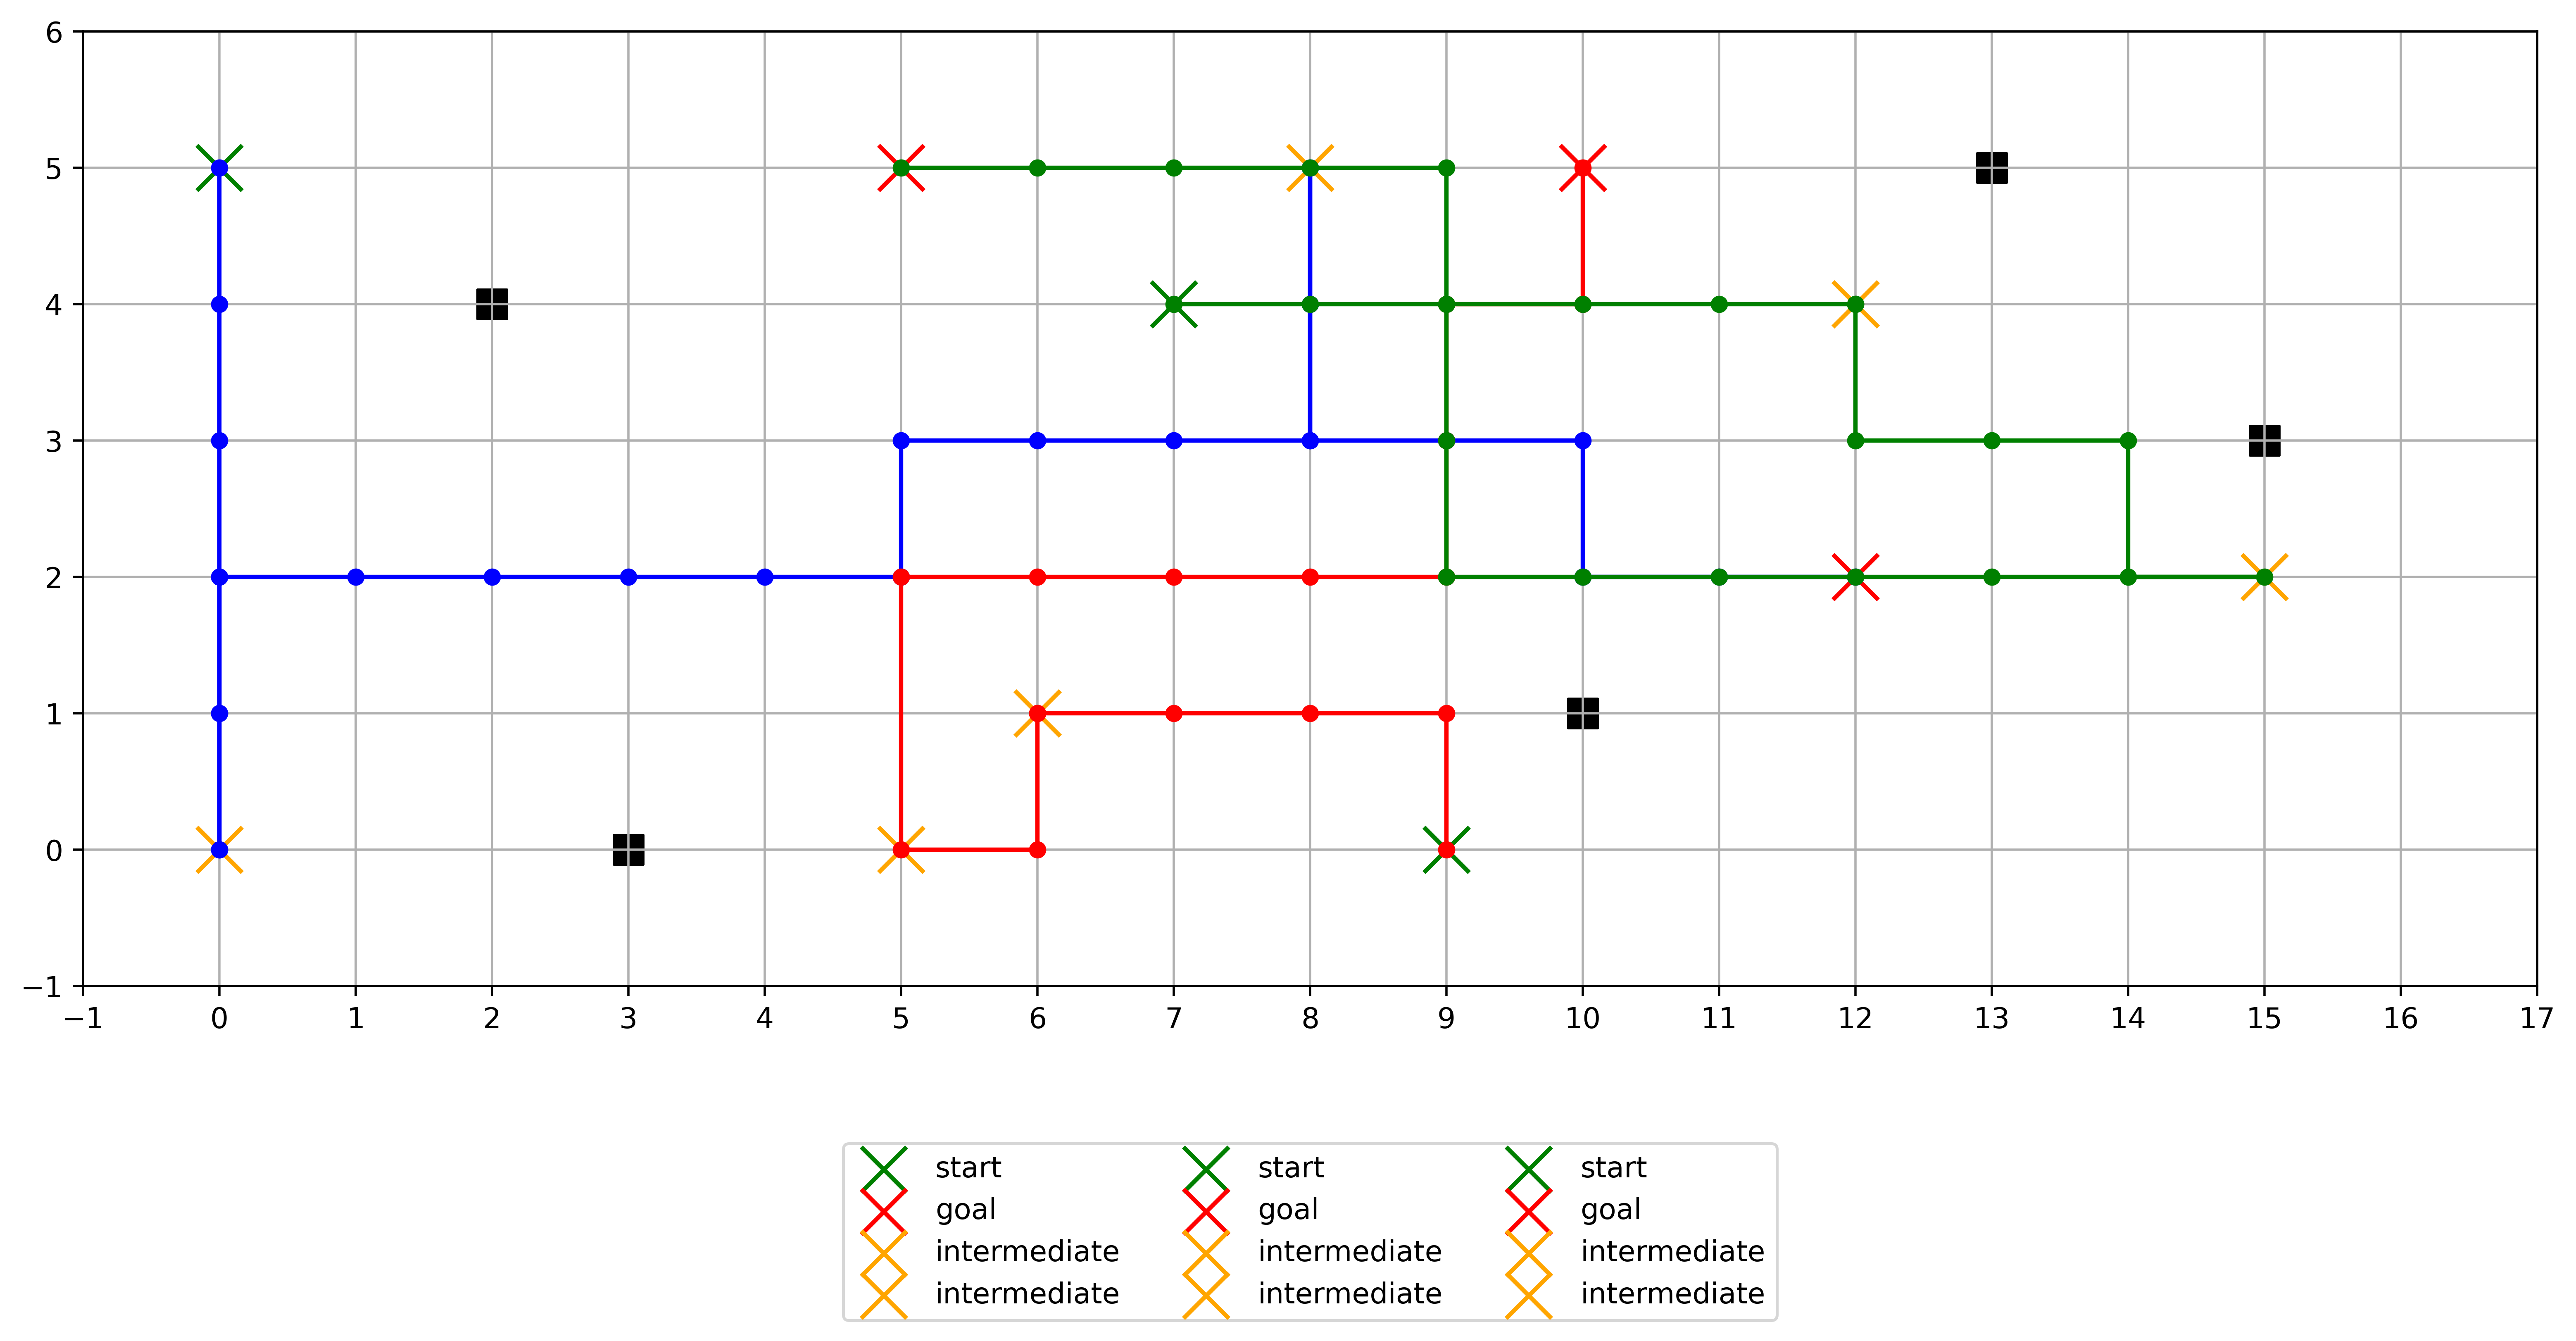

In [ ]:
n = 6
m = 17
obstacles = {(0, 13), (2, 15), (4, 10), (5, 3), (1, 2)}
grid = Grid(n, m, obstacles)

start1 = (0, 0)
intermediate_goals1 = [(5, 0), (0, 8)]  # Add an additional intermediate goal
goal1 = (3, 12)

start2 = (5, 9)
intermediate_goals2 = [(4, 6), (5, 5)]  # Add an additional intermediate goal
goal2 = (0, 10)

start3 = (1, 7)
intermediate_goals3 = [(1, 12), (3, 15)]  # Add an additional intermediate goal
goal3 = (0, 5)

path1 = astar_with_intermediate_goals(grid, start1, intermediate_goals1, goal1)
path2 = astar_with_intermediate_goals(grid, start2, intermediate_goals2, goal2)
path3 = astar_with_intermediate_goals(grid, start3, intermediate_goals3, goal3)

paths = [path1, path2, path3]
print(f'Initial conflicts: {conflict_detection(paths)}')

resolved_paths = resolve_conflicts(paths, grid)

if resolved_paths is None:
    print("Conflict resolution failed.")
else:
    print("Resolved paths:\n")
    for i, p in enumerate(resolved_paths):
        print(f"Agent {i + 1}: {p}\n")

print(f'After conflict resolution: {conflict_detection(resolved_paths)}')

plt.figure(figsize=(grid.m, grid.n), dpi=500)
plot_grid(grid, start1, intermediate_goals1, goal1, color='blue')
plot_grid(grid, start2, intermediate_goals2, goal2, color='red')
plot_grid(grid, start3, intermediate_goals3, goal3, color='green')


plt.figure(figsize=(grid.m, grid.n), dpi=500)
plot_grid(grid, start1, intermediate_goals1, goal1, resolved_paths[0], color='blue')
plot_grid(grid, start2, intermediate_goals2, goal2, resolved_paths[1], color='red')
plot_grid(grid, start3, intermediate_goals3, goal3, resolved_paths[2], color='green')


# **Permutations of Pick-up and Delivery for optimization**

The *optimize* function is responsible for finding the most efficient order of task execution for a group of robots given a grid, robot start-end pairs, and sets of pick-up and delivery locations. The goal is to minimize the total time taken for all the robots to complete their tasks.

In [ ]:
def optimize(grid, robot, pick_and_deliver):

  # Generate all permutations of the list pick_and_deliver
  permutations = list(itertools.permutations(pick_and_deliver))

  # Convert the permutations to a list
  permutations = list(permutations)

  # Measuring the time taken in each path by the number of squares traversed.
  # The lesser length of path means the lesser time taken
  time = []
  path = []

  for p in permutations:

    path1 = astar_with_intermediate_goals(grid, robot[0][0], p[0], robot[0][1])
    path2 = astar_with_intermediate_goals(grid, robot[1][0], p[1], robot[1][1])
    path3 = astar_with_intermediate_goals(grid, robot[2][0], p[2], robot[2][1])

    paths = [path1, path2, path3]
    resolved_paths = resolve_conflicts(paths, grid)

    path.append(resolved_paths)

    length = 0

    for _, p in enumerate(resolved_paths):

      length += len(p)

    time.append(length)

  # print(time)
  # print(path)

  # Taking the index of the path with miniumum time
  min_index  = time.index(min(time))
  best_path = path[min_index]
  order_of_intermediates = permutations[min_index]

  return order_of_intermediates, best_path

Optimized order: 
Agent 1: start: (0, 0); pick-up: (5, 0); deliver: (0, 8); end: (3, 12)
Agent 2: start: (5, 9); pick-up: (1, 12); deliver: (3, 15); end: (0, 10)
Agent 3: start: (1, 7); pick-up: (4, 6); deliver: (5, 5); end: (0, 5)

Best Route: 
Agent 1: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 0), (4, 0), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (2, 5), (2, 6), (2, 7), (2, 8), (1, 8), (0, 8), (2, 8), (2, 9), (2, 10), (3, 10), (3, 11), (3, 12)]

Agent 2: [(5, 9), (4, 9), (3, 9), (3, 10), (2, 10), (2, 11), (2, 12), (1, 12), (1, 12), (2, 12), (2, 13), (2, 14), (3, 14), (3, 15), (3, 13), (3, 12), (2, 12), (1, 12), (1, 11), (0, 11), (0, 10)]

Agent 3: [(1, 7), (2, 7), (2, 6), (3, 6), (4, 6), (4, 6), (5, 6), (5, 5), (3, 5), (2, 5), (1, 5), (0, 5)]



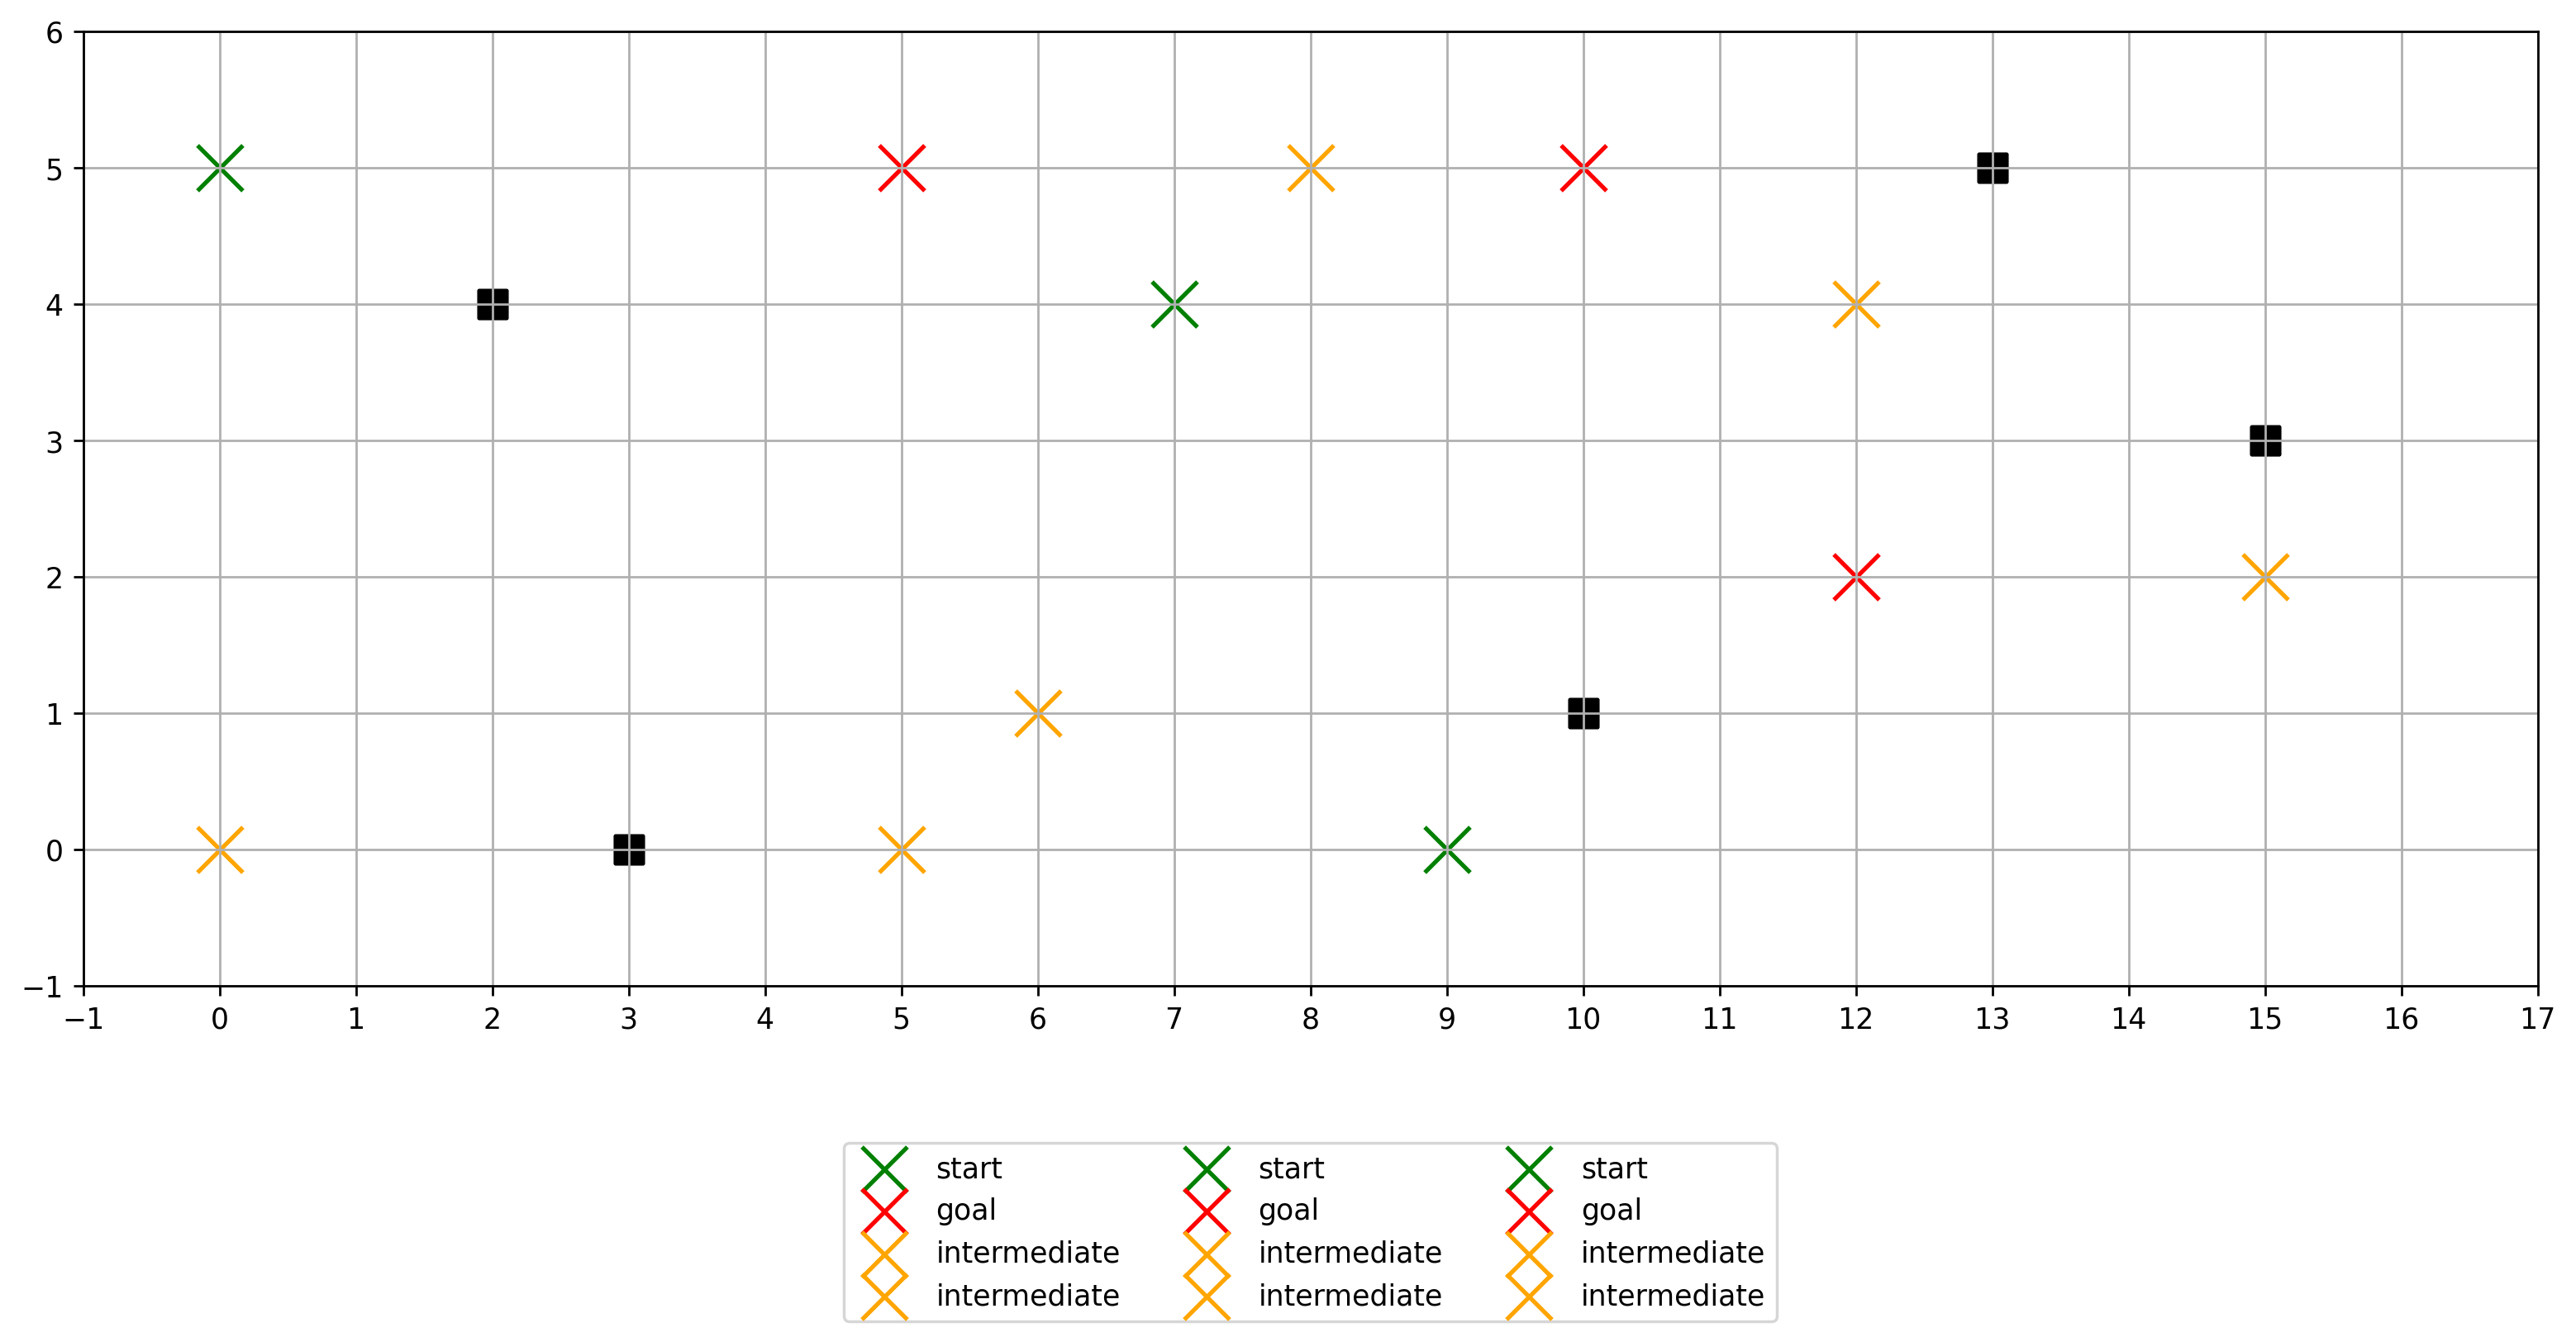

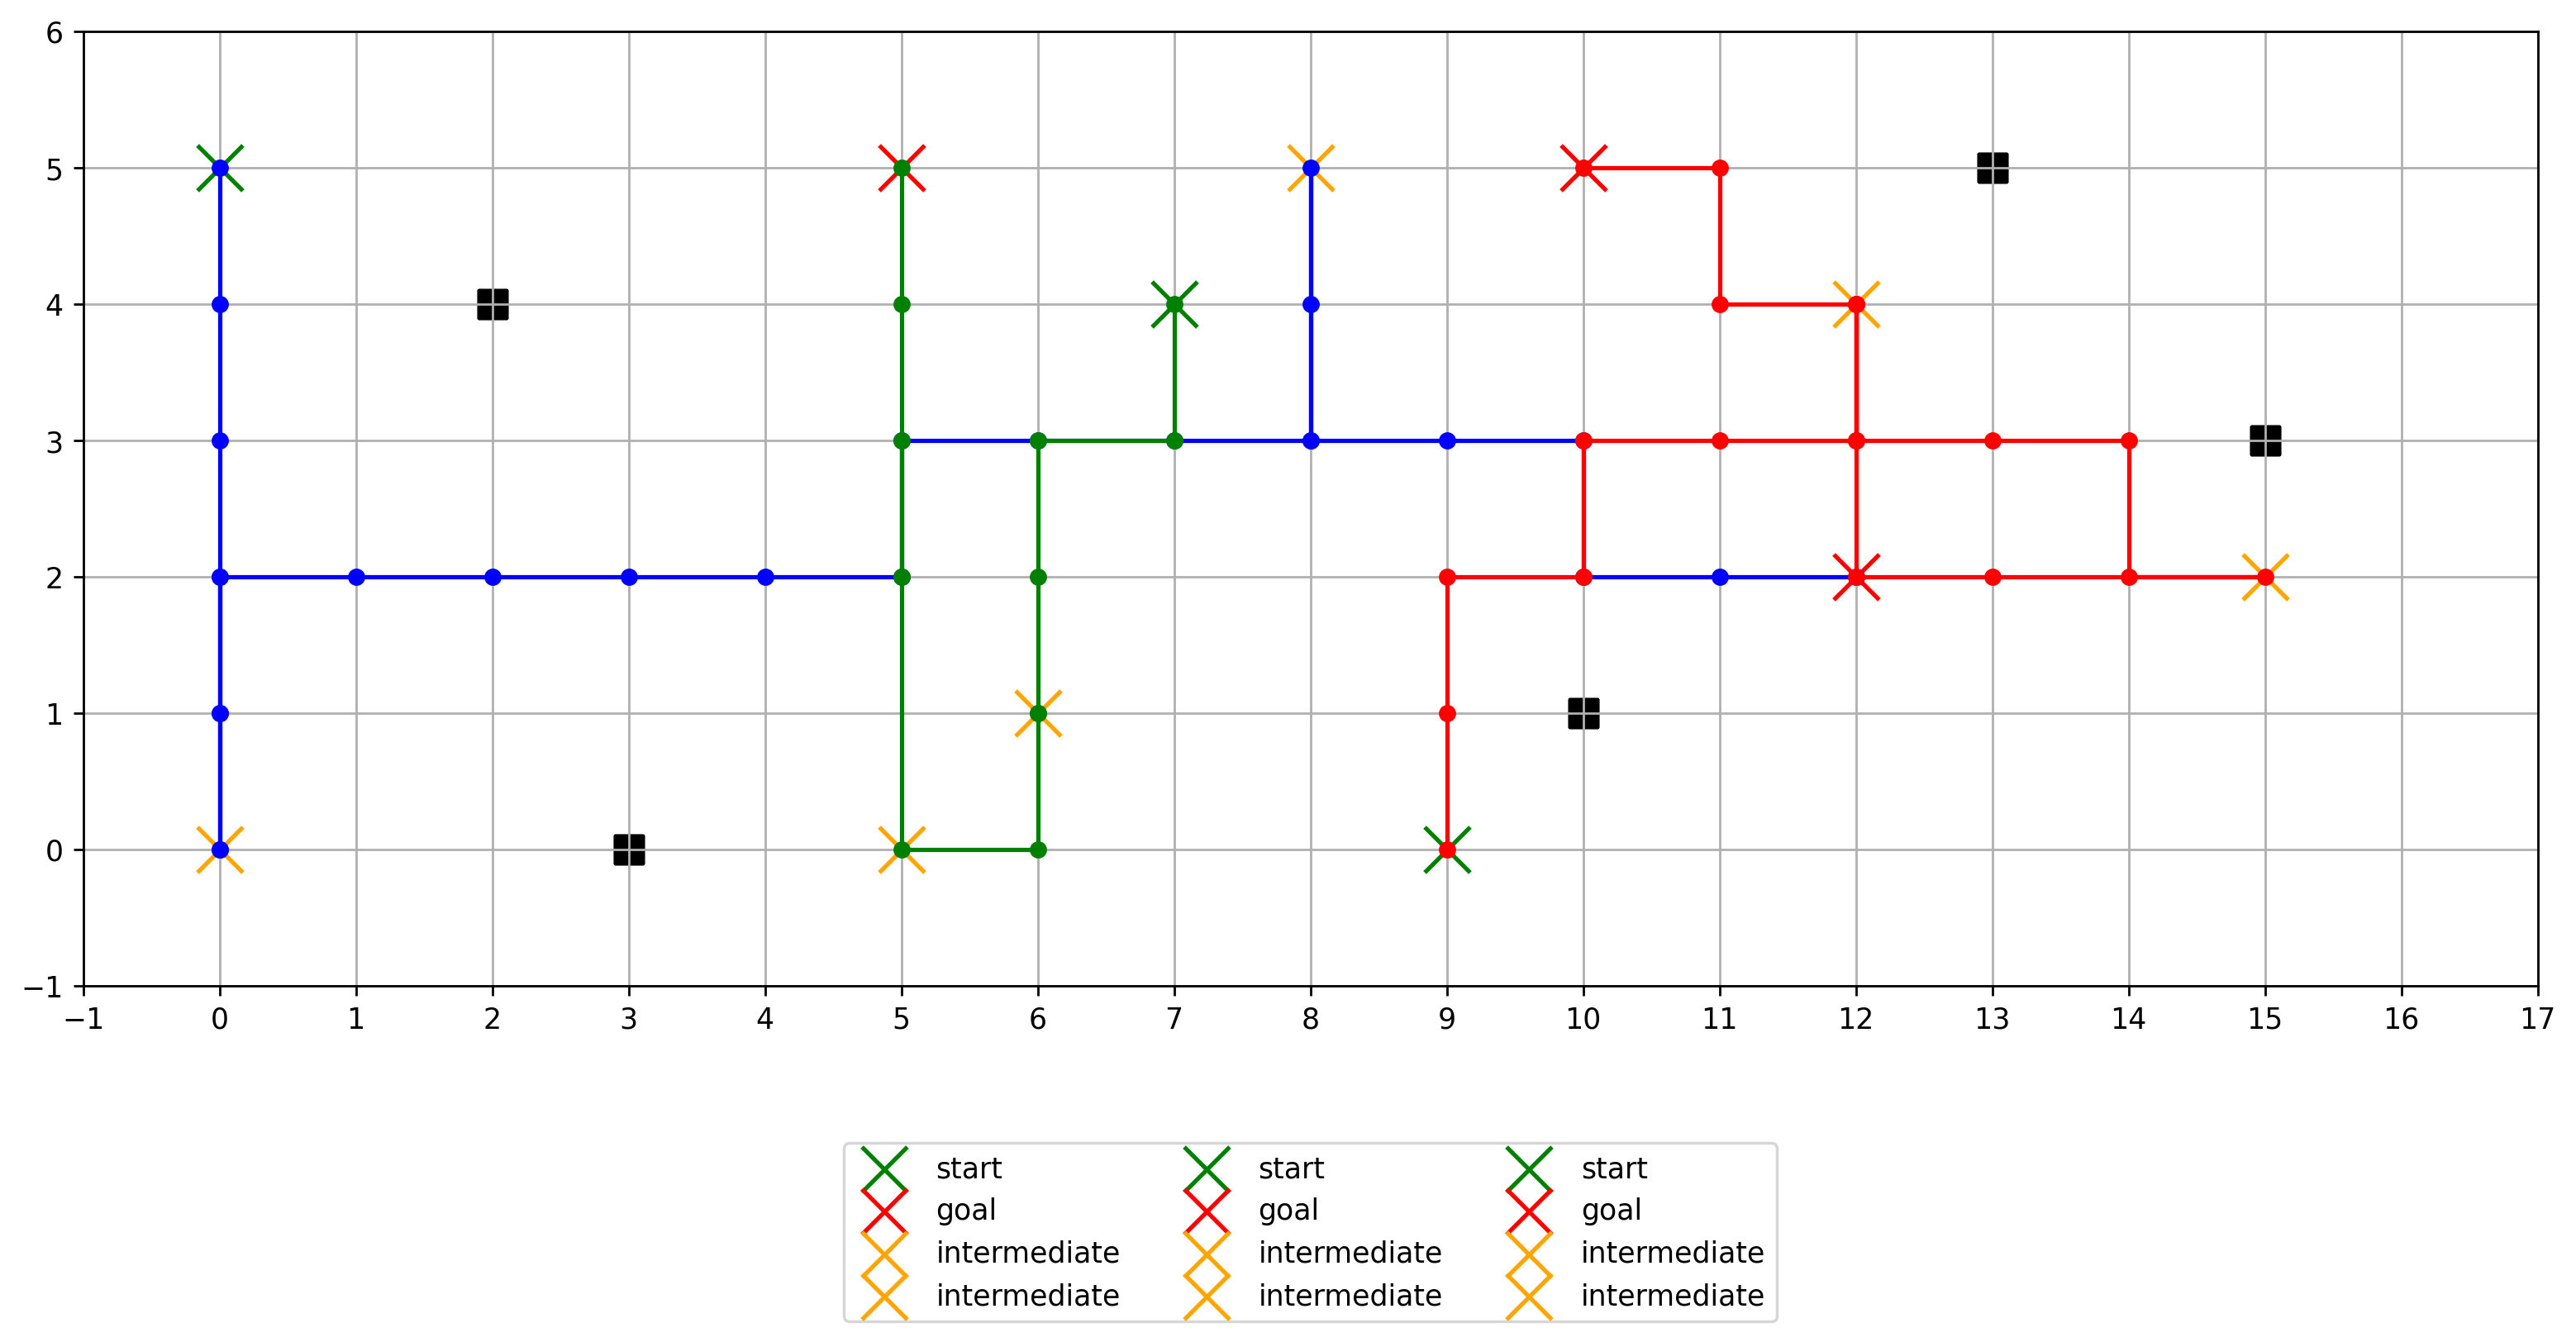

In [ ]:
n = 6
m = 17
obstacles = {(0, 13), (2, 15), (4, 10), (5, 3), (1, 2)}
grid = Grid(n, m, obstacles)

# Defining pick-up and drop tuples

intermediate_goals1 = [(5, 0), (0, 8)]
intermediate_goals2 = [(4, 6), (5, 5)]
intermediate_goals3 = [(1, 12), (3, 15)]

pick_and_deliver = [intermediate_goals1, intermediate_goals2, intermediate_goals3]

# Defining each bot as start-end pair
robot = []

robot1 = [(0, 0), (3, 12)]
robot2 = [(5,9), (0, 10)]
robot3 = [(1, 7), (0, 5)]

robot.append(robot1)
robot.append(robot2)
robot.append(robot3)

# Finding the best pick and drop order for individual bots and hence the best path
order_of_intermediates, best_path = optimize(grid, robot, pick_and_deliver)

print('Optimized order: ')

for i in range(3):
  print(f'Agent {i+1}: start: {robot[i][0]}; pick-up: {order_of_intermediates[i][0]}; deliver: {order_of_intermediates[i][1]}; end: {robot[i][1]}')

# Taking the output of the desired trajectory
print('\nBest Route: ')
for i, p in enumerate(best_path):
  print(f"Agent {i + 1}: {p}\n")

plt.figure(figsize=(grid.m, grid.n), dpi=250)

plot_grid(grid, robot[0][0], order_of_intermediates[0], robot[0][1], color='blue')
plot_grid(grid, robot[1][0], order_of_intermediates[1], robot[1][1], color='red')
plot_grid(grid, robot[2][0], order_of_intermediates[2], robot[2][1], color='green')


plt.figure(figsize=(grid.m, grid.n), dpi=250)
plot_grid(grid, robot[0][0], order_of_intermediates[0], robot[0][1], best_path[0], color='blue')
plot_grid(grid, robot[1][0], order_of_intermediates[1], robot[1][1], best_path[1], color='red')
plot_grid(grid, robot[2][0], order_of_intermediates[2], robot[2][1], best_path[2], color='green')